In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import cv2
import torch
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Data prepairing and preprocessing

## Data Object

In [4]:
# Video Dataset Definition

class VideoDataset(Dataset):
    def __init__(self, root_dir, num_frames=16, train=True):
        self.root_dir = root_dir
        self.classes = os.listdir(root_dir)
        self.videos = []
        self.num_frames = num_frames
        self.train = train

        classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}


        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for file in os.listdir(class_path):
                if file.endswith(('.mp4', '.avi', '.mov')):
                    self.videos.append({
                        'path': os.path.join(class_path, file),
                        'label': label
                    })

    def __len__(self):
        return len(self.videos)

    def read_video(self, path):
        cap = cv2.VideoCapture(path)
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        cap.release()
        return frames

    def sample_frames(self, frames):
        total = len(frames)
        if total == 0:
            return None
        indices = np.linspace(0, total - 1, self.num_frames, dtype=int)
        return [frames[i] for i in indices]

    def get_transform(self):
        """Different for train vs validation."""
        base = [
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])
        ]

        if not self.train:
            return transforms.Compose(base)

        # training augmentation (one per video)
        augmentations = [
            transforms.RandomHorizontalFlip(p=1.0),
            transforms.ColorJitter(brightness=0.3),
            transforms.ColorJitter(contrast=0.3),
            transforms.RandomRotation(degrees=10),
            None
        ]
        aug = random.choice(augmentations)
        if aug is not None:
            return transforms.Compose([aug] + base)
        return transforms.Compose(base)

    def __getitem__(self, idx):
        video_info = self.videos[idx]
        frames = self.read_video(video_info['path'])
        frames = self.sample_frames(frames)
        transform = self.get_transform()

        frames = [transform(Image.fromarray(f)) for f in frames]
        video_tensor = torch.stack(frames)  # [T, C, H, W]
        label = torch.tensor(video_info['label'])
        return video_tensor, label


## Splitting & Building the data loader

In [5]:
#  Dataset Split (Train / Val)
full_dataset = VideoDataset(root_dir="/content/drive/MyDrive/project/Shop DataSet", num_frames=16, train=True)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Mark validation dataset as non-augmented
val_dataset.dataset.train = False

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)}")


Train: 481 | Val: 121


In [6]:
print(full_dataset.class_to_idx)

{'non shop lifters': 0, 'shop lifters': 1}


## visualizing augmented videos

In [7]:
# import os
# import cv2
# import torch
# import numpy as np
# from IPython.display import HTML, display
# from base64 import b64encode

# def show_video_clip(video_tensor, label, fps=10):
#     """
#     Display a video tensor inline (supports both (T, C, H, W) and (C, T, H, W))
#     """
#     # Ensure it's detached from GPU
#     video_tensor = video_tensor.detach().cpu()

#     # Handle different tensor shapes
#     if video_tensor.shape[0] == 3:  # (C, T, H, W)
#         video_tensor = video_tensor.permute(1, 2, 3, 0)  # -> (T, H, W, C)
#     elif video_tensor.shape[-1] != 3:  # (T, C, H, W)
#         video_tensor = video_tensor.permute(0, 2, 3, 1)  # -> (T, H, W, C)

#     # Denormalize (if normalized between -1 and 1)
#     video_tensor = (video_tensor * 0.5 + 0.5).clamp(0, 1)

#     # Convert to NumPy uint8
#     video_np = (video_tensor.numpy() * 255).astype(np.uint8)

#     # Save temporary mp4
#     temp_path = "/content/drive/MyDrive/project/temp_video.mp4"
#     out = cv2.VideoWriter(temp_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (video_np.shape[2], video_np.shape[1]))

#     for frame in video_np:
#         if frame.shape[-1] == 1:  # grayscale
#             frame = np.repeat(frame, 3, axis=-1)
#         out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
#     out.release()

#     # Convert to HTML video
#     mp4 = open(temp_path, 'rb').read()
#     data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

#     display(HTML(f"""
#     <video width="480" height="360" controls>
#         <source src="{data_url}" type="video/mp4">
#     </video>
#     <p><b>Label:</b> {'Shoplifter' if label == 1 else 'Non-Shoplifter'}</p>
#     """))


# def preview_videos(dataloader, num_videos=2):
#     """
#     Preview a few video samples inline as playable videos.
#     """
#     data_iter = iter(dataloader)
#     videos, labels = next(data_iter)

#     for i in range(min(num_videos, len(videos))):
#         show_video_clip(videos[i], labels[i].item(), fps=2)


In [8]:
# preview_videos(train_loader, 2)

# CNN + LSTM

## Model building

In [12]:
class CNNLSTM(nn.Module):
    def __init__(self,hidden_size = 256, num_layers = 1):
        super(CNNLSTM, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((4, 4))
        )

        self.lstm = nn.LSTM(
            input_size=64*4*4,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(256, 1)

    def forward(self, x):
        # x: [B, T, C, H, W]
        batch_size, seq_len, C, H, W = x.size()
        cnn_out = []
        for t in range(seq_len):
            frame_feat = self.cnn(x[:, t])
            frame_feat = frame_feat.view(batch_size, -1)
            cnn_out.append(frame_feat)
        cnn_out = torch.stack(cnn_out, dim=1)  # [B, T, features]
        lstm_out, _ = self.lstm(cnn_out)
        out = self.fc(lstm_out[:, -1, :])
        return out.squeeze(1)

## Training loop function

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [24]:
# Training Loop
model = CNNLSTM()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10
model.to(device)
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs,
    checkpoint_path="/content/drive/MyDrive/project/Checkpoints/best_CNN_LSTM_model.pth"
):
    best_val_loss = float("inf")


    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        # ---- TRAIN ----
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for videos, labels in train_loader:
            videos = videos.to(device)
            labels = labels.float().to(device)
            optimizer.zero_grad()
            outputs = model(videos)
            loss = criterion(outputs, labels)

            preds = (torch.sigmoid(outputs) > 0.5).long()
            running_corrects += torch.sum(preds == labels.long())
            running_loss += loss.item() * videos.size(0)

            loss.backward()
            optimizer.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f"Train Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")

        # ---- VALIDATION ----
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for videos, labels in val_loader:
                labels = labels.float().to(device)
                videos = videos.to(device)

                outputs = model(videos)
                loss = criterion(outputs, labels)

                preds = (torch.sigmoid(outputs) > 0.5).long()
                val_corrects += torch.sum(preds == labels.long())
                val_loss += loss.item() * videos.size(0)

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        # ---- STORE RESULTS ----
        history["train_loss"].append(epoch_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(epoch_acc.item())
        history["val_acc"].append(val_acc.item())

        print(f"Train Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")
        # ---- SAVE CHECKPOINT ----
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
            torch.save(model.state_dict(), checkpoint_path)
            print(f"✅ Best model updated and saved at: {checkpoint_path}")

    print("\nTraining complete.")
    print(f"Lowest Val Loss: {best_val_loss:.4f}")
    return model, history


## Training

In [20]:
model, history0 = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)


Epoch 1/10
------------------------------
Train Loss: 0.6910  Acc: 0.5301
Train Loss: 0.6910 | Acc: 0.5301
Val   Loss: 0.7088 | Acc: 0.5124
✅ Best model updated and saved at: /content/drive/MyDrive/project/Checkpoints/best_CNN_LSTM_model.pth

Epoch 2/10
------------------------------
Train Loss: 0.6904  Acc: 0.5447
Train Loss: 0.6904 | Acc: 0.5447
Val   Loss: 0.6942 | Acc: 0.5124
✅ Best model updated and saved at: /content/drive/MyDrive/project/Checkpoints/best_CNN_LSTM_model.pth

Epoch 3/10
------------------------------
Train Loss: 0.6885  Acc: 0.5447
Train Loss: 0.6885 | Acc: 0.5447
Val   Loss: 0.6886 | Acc: 0.5124
✅ Best model updated and saved at: /content/drive/MyDrive/project/Checkpoints/best_CNN_LSTM_model.pth

Epoch 4/10
------------------------------


KeyboardInterrupt: 

In [22]:
model, history1 = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)


Epoch 1/10
------------------------------
Train Loss: 0.6940  Acc: 0.5364
Train Loss: 0.6940 | Acc: 0.5364
Val   Loss: 0.6935 | Acc: 0.5124
✅ Best model updated and saved at: /content/drive/MyDrive/project/Checkpoints/best_CNN_LSTM_model.pth

Epoch 2/10
------------------------------
Train Loss: 0.6899  Acc: 0.5447
Train Loss: 0.6899 | Acc: 0.5447
Val   Loss: 0.6942 | Acc: 0.5124

Epoch 3/10
------------------------------
Train Loss: 0.6921  Acc: 0.5447
Train Loss: 0.6921 | Acc: 0.5447
Val   Loss: 0.6905 | Acc: 0.5124
✅ Best model updated and saved at: /content/drive/MyDrive/project/Checkpoints/best_CNN_LSTM_model.pth

Epoch 4/10
------------------------------
Train Loss: 0.6892  Acc: 0.5405
Train Loss: 0.6892 | Acc: 0.5405
Val   Loss: 0.6833 | Acc: 0.5124
✅ Best model updated and saved at: /content/drive/MyDrive/project/Checkpoints/best_CNN_LSTM_model.pth

Epoch 5/10
------------------------------
Train Loss: 0.6689  Acc: 0.5904
Train Loss: 0.6689 | Acc: 0.5904
Val   Loss: 0.4736 | A

In [25]:
optimizer = optim.Adam(model.parameters(), lr=1e-4) #lowering learning rate
num_epochs = 5
model, history2 = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, checkpoint_path="/content/drive/MyDrive/project/Checkpoints/best_CNN_LSTM_model2.pth" )


Epoch 1/5
------------------------------
Train Loss: 0.5039  Acc: 0.8254
Train Loss: 0.5039 | Acc: 0.8254
Val   Loss: 0.3997 | Acc: 0.8678
✅ Best model updated and saved at: /content/drive/MyDrive/project/Checkpoints/best_CNN_LSTM_model2.pth

Epoch 2/5
------------------------------
Train Loss: 0.4495  Acc: 0.8420
Train Loss: 0.4495 | Acc: 0.8420
Val   Loss: 0.3442 | Acc: 0.9174
✅ Best model updated and saved at: /content/drive/MyDrive/project/Checkpoints/best_CNN_LSTM_model2.pth

Epoch 3/5
------------------------------
Train Loss: 0.4346  Acc: 0.8441
Train Loss: 0.4346 | Acc: 0.8441
Val   Loss: 0.3279 | Acc: 0.9174
✅ Best model updated and saved at: /content/drive/MyDrive/project/Checkpoints/best_CNN_LSTM_model2.pth

Epoch 4/5
------------------------------
Train Loss: 0.4328  Acc: 0.8420
Train Loss: 0.4328 | Acc: 0.8420
Val   Loss: 0.3230 | Acc: 0.9174
✅ Best model updated and saved at: /content/drive/MyDrive/project/Checkpoints/best_CNN_LSTM_model2.pth

Epoch 5/5
-----------------

In [ ]:
model, history3 = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, checkpoint_path="/content/drive/MyDrive/project/Checkpoints/best_CNN_LSTM_model2.pth" )

# Evaluation

## Loading best model

In [27]:
best_model = CNNLSTM()
best_model.load_state_dict(torch.load("/content/drive/MyDrive/project/Checkpoints/best_CNN_LSTM_model2.pth"))
best_model.to(device)

CNNLSTM(
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): AdaptiveAvgPool2d(output_size=(4, 4))
  )
  (lstm): LSTM(1024, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

## Evaluation

In [28]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

best_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for videos, labels in val_loader:
        videos, labels = videos.to(device), labels.to(device)
        outputs = model(videos)
        preds = (torch.sigmoid(outputs) > 0.5).long()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 5️⃣ Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Validation Accuracy: 0.9174
Precision: 0.8769
Recall: 0.9661
F1 Score: 0.9194


In [29]:
# 1️⃣ Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

# 2️⃣ Classification report (precision, recall, f1-score)
report = classification_report(all_labels, all_preds, target_names=["Non-Shoplifting", "Shoplifting"])
print("\nClassification Report:")
print(report)

Confusion Matrix:
[[54  8]
 [ 2 57]]

Classification Report:
                 precision    recall  f1-score   support

Non-Shoplifting       0.96      0.87      0.92        62
    Shoplifting       0.88      0.97      0.92        59

       accuracy                           0.92       121
      macro avg       0.92      0.92      0.92       121
   weighted avg       0.92      0.92      0.92       121



## plotting history

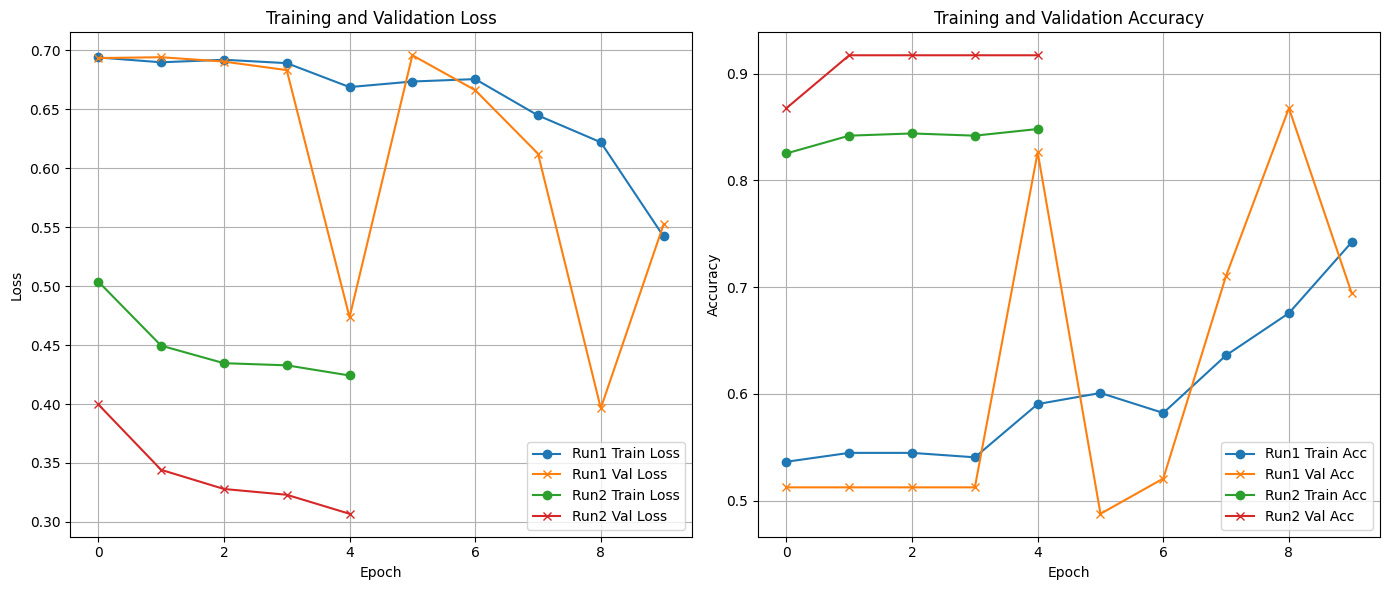

In [32]:
import matplotlib.pyplot as plt

def plot_history(histories, labels):
    """
    histories: list of history dictionaries
    labels: list of labels for each history (e.g., ["run1", "run2", "run3"])
    """
    plt.figure(figsize=(14, 6))

    # ----- Plot Loss -----
    plt.subplot(1, 2, 1)
    for history, label in zip(histories, labels):
        plt.plot(history["train_loss"], marker='o', label=f"{label} Train Loss")
        plt.plot(history["val_loss"], marker='x', label=f"{label} Val Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # ----- Plot Accuracy -----
    plt.subplot(1, 2, 2)
    for history, label in zip(histories, labels):
        plt.plot(history["train_acc"], marker='o', label=f"{label} Train Acc")
        plt.plot(history["val_acc"], marker='x', label=f"{label} Val Acc")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Example usage:
plot_history([history1, history2], ["Run1", "Run2"])